In [1]:
from IPython.core.display import HTML

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from scipy.integrate import odeint, trapz, simps
from IPython.display import HTML

from scipy.fft import fft, ifft
matplotlib.rcParams.update({'font.size': 14})


# 1.a Pseudospectral method

based on the code in:´

https://www.youtube.com/watch?v=rsdqvrldgHM&list=WL&index=181

To do:
- clean up code SCFT method specialy
- put titles and axis laels on graphs and all of that FIX THE X AXIS FOR EACH OF THE PLOTS
- use argmin to find the minimum maximal deviation
- comment the code

Calculate the single chain partition function to make sure that propagators are correct. This partition function should be constant across all 's'

# Explicit euler method 

 


In [24]:
# ----------------------
# Global Constants------
# ----------------------
Re = 1.0
# number of points in space 
Nx = 256
# number of beads in the polymer contour
N = 64
# polymer contour
s = np.linspace(0,1,N)
# cutting point of the polymer diving A and B
F = 1/2


In [25]:
def spectral_q(q,t,wx,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((Re)**2)/6
    # n that indexes the fourier modes*1.j
    n = np.fft.fftfreq(nx)*nx*2*np.pi/l
    ds = t[1]-t[0]
    return np.exp(-1*wx*ds/2.0)* ifft( np.exp(-a*n**2*ds)*fft(np.exp(-wx*ds/2.0)*q) ).real

def spectral_q_dag(q,t,wx,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((Re)**2)/6
    # n that indexes the fourier modes *1.j
    n = np.fft.fftfreq(nx)*nx*2*np.pi/l
    ds = t[0]-t[1]

    return (np.exp(wx*ds/2.0)* ifft( np.exp(a*n**2*ds)*fft(np.exp(wx*ds/2.0)*q)).real)

# re,x ,s, f ,wa, wb
def calculate_densities(nx,f,L, wa, wb):
        # Calculates the densities of given wa and wb
    
    # args -> re: scalar, Re experimental paramaterer
    # nx: scalar, number if spatial postions
    # s: array, position of chains
    # f: scalar, cut off point between A and B parts
    # wa: array, w field for the first half of the copolymer
    # wb: array, w field for the second half of the copolymer
    
    # returs-> phi_a, phi_b arrays representing the densities 
    q = [np.ones(Nx)]
    q_dag = [np.ones(Nx)]
    
    # for q
    w_curr = wa
    for i in range(0,len(s)-1):
        if i==int(len(s)*f)-1:
            w_curr = wb

        q_next = spectral_q(q[i],s,w_curr,nx,L)
        q.append(list(q_next))
        
    q = np.asarray(q)
    
    # Same process for q dagger
    w_curr = wb
    for i in range(0,len(s)-1):
        if i==int(len(s)*f-1):
            w_curr = wa

        q_dag_next = spectral_q_dag(q_dag[i],s,w_curr,nx,L)
        q_dag.append(list(q_dag_next))
    q_dag =  np.asarray(q_dag)
    q_dag = np.flip(q_dag)
    
    return q, q_dag


## First approximation

In [26]:
# length of the system
L = 2*Re

# spatial discretization 
x = np.linspace(0,Nx, Nx)
x = x*L/Nx

wa = 5*np.cos(2*np.pi*x/L)
wb = -wa

In [27]:
q,q_dag = calculate_densities(Nx,F,L, wa, wb)   

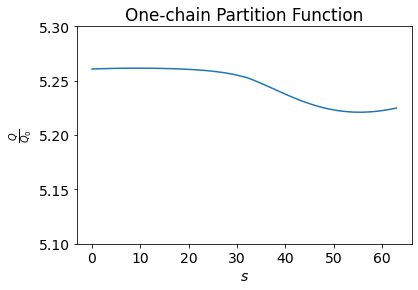

In [28]:
Q_Q0 = trapz(q*q_dag, x,axis=1)
plt.ylim(5.1,5.3)
plt.plot(Q_Q0)

plt.title('One-chain Partition Function')
plt.ylabel(r'$\frac{Q}{Q_0}$')
plt.xlabel(r'$s$')
plt.savefig('q_q0.png')


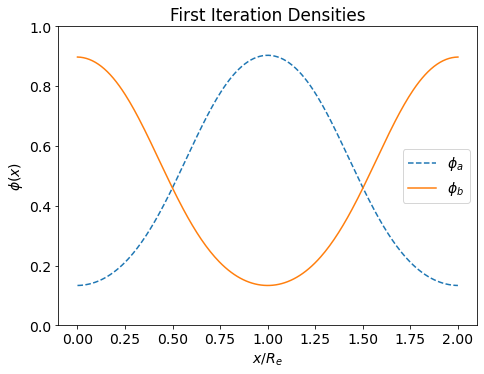

In [29]:
prod_q = q*q_dag
phi_a = (L/np.max(Q_Q0))*trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)
phi_b = (L/np.max(Q_Q0))*trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)

plt.figure(figsize=(7.5,5.5))
plt.title('First Iteration Densities')
plt.plot(x, phi_a, label='$\phi_a$',linestyle='dashed')
plt.plot(x, phi_b,label='$\phi_b$')
plt.ylim(0,1)
plt.xlabel(r'$x/R_e$')
plt.ylabel(r'$\phi(x)$')
plt.legend()

plt.savefig('first_densities.png')




## SCFT

First Iteration of scft

In [66]:
def SCFT(X, L, Chi_N, Alpha):
    # big method to run SCFT as a functions of the arguments. Includes piccard iteration and pseudospectral parts
    
    # parameter definitions and initial values
    target_deviation_1 = 10**(-5)
    target_deviation_2 = 10**(-5)

    wa = 5*np.cos(2*np.pi*X/L)
    wb = -wa

    consistency_1 = []
    consistency_2 = []

    phi_a_list = []
    phi_b_list = []

    deviation_1 = []
    deviation_2 = []

    Q0_list = []
    w_minus_list = []
    w_plus_list =  []
    
    # calculate the first approximation for the densities
    q,q_dag = calculate_densities(Nx,F,L, wa, wb)   
    Q_Q0 = trapz(q*q_dag, X ,axis=1)
    prod_q = q*q_dag

    # starting point 
    w_minus_old = wa - wb
    w_plus_old = wa + wb

    phi_a_old = phi_a.copy()
    phi_b_old = phi_b.copy()
    
    stop_loop = False

    i = 0
    while(stop_loop==False):
        # update the omegas
        w_minus = Alpha*( Chi_N*( phi_b_old - phi_a_old ) - w_minus_old ) + w_minus_old
        w_plus = Alpha*( Chi_N*( phi_b_old + phi_a_old ) - 1 ) + w_plus_old

        # calculate the new fields
        wa_new = 0.5*(w_minus + w_plus)
        wb_new = - 0.5*(w_minus - w_plus)

        # calculate the new propagators and densities
        # (s,Nx,F,L, wa, wb) 
        q, q_dag = calculate_densities(Nx,F,L,wa_new, wb_new)
        prod_q = q*q_dag

        Q_Q0 = trapz(prod_q, X,axis=1)
        
            # make sure we don't end up dividing by zero due to Q_Q0
        try:
            phi_a_new = trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)*(L/np.max(Q_Q0))
            phi_b_new = trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)*(L/np.max(Q_Q0))

        except:
            print("divide by zero enconuntered")
            continue
         
        # check that restrictions hold
        # first condition right hand side
        rhs_1 = Chi_N*(phi_a_new - phi_b_new)
        rhs_2 = phi_a_new + phi_b_new

        dev_1 = np.abs(w_minus + rhs_1)
        dev_2 = np.abs(1 - rhs_2)


        # save quantities of interest
        consistency_1.append(list(rhs_1))
        consistency_2.append(list(rhs_2))

        phi_a_list.append(list(phi_a_new))
        phi_b_list.append(list(phi_b_new))

        deviation_1.append(list((dev_1)))
        deviation_2.append(list(dev_2))

        Q0_list.append(list(Q_Q0))

        w_minus_list.append(list(w_minus))
        w_plus_list.append(list(w_plus))

        # update values for the next iteration
        w_minus_old = w_minus.copy()
        w_plus_old = w_plus.copy()

        phi_a_old = phi_a_new.copy()
        phi_b_old = phi_b_new.copy()

        # check whether the stop condition holds
        if((max(dev_1)<= target_deviation_1) or (max(dev_2)<= target_deviation_2)):
            # by comparing the maximum of dev_1 we make sure that the condition holds for every x
            stop_loop = True
            
        # add this to show something while the loop runs
        if(i%500==0):
            print("elapsed iterations: ", i)
            print("current max deviations:", (max(dev_1), max(dev_2)))
        
        # stop after a certain number of iterations as the thing starts to diverge
        if i==4000:
            stop_loop = True
            
        i+=1  

            
    return phi_a_list, phi_b_list, Q0_list ,w_minus_list, w_plus_list, deviation_1, deviation_2

In [67]:
def calculate_free_energy(X, l ,wa_f, wb_f,phia_f, phib_f,q0,chi_n):
    # calculate free energy
    integral_term = - wa_f*np.asarray(phia_f) - wb_f*np.asarray(phib_f)\
                    + chi_n*np.asarray(phia_f)*np.asarray(phib_f)

    delta_f = -1*np.log((1/l)*max(q0)) + (1/l) * trapz(integral_term, X,axis=0)
    
    return delta_f

In [68]:
L = 2*Re
chi_n = 15
alpha = 0.1


In [69]:
phi_a_list, phi_b_list, Q0_list ,w_minus_list, w_plus_list, deviation_1, deviation_2 = \
                    SCFT(x,L, chi_n, alpha)


elapsed iterations:  0
current max deviations: (1.526908625010531, 0.07565050669069928)
elapsed iterations:  500
current max deviations: (0.00033397601208839944, 0.019558435060369583)
elapsed iterations:  1000
current max deviations: (0.02759030778679028, 0.8542188750120369)
elapsed iterations:  1500
current max deviations: (0.006672906399138867, 0.8837208557788437)
elapsed iterations:  2000
current max deviations: (0.0034104506833818604, 0.8960899246413176)
elapsed iterations:  2500
current max deviations: (0.0021898522960996925, 0.9036253251244365)
elapsed iterations:  3000
current max deviations: (0.0015741945122567103, 0.9089218506973811)
elapsed iterations:  3500
current max deviations: (0.0012102114989012147, 0.9129457408186371)
elapsed iterations:  4000
current max deviations: (0.0009726299606473976, 0.9161575275948322)


In [70]:
# show the best deviations achieved
max_dev = [max(x) for x in deviation_1]
index_min = np.argmin(max_dev)
print('Minimum deviation achived for condition one:', min(max_dev), ' at iteration', index_min)

max_dev = [max(x) for x in deviation_2]
index_min = np.argmin(max_dev)
print('Minimum deviation achived for condition one:', min(max_dev), ' at iteration', index_min)



Minimum deviation achived for condition one: 1.16370847376146e-05  at iteration 416
Minimum deviation achived for condition one: 0.019526602069477872  at iteration 443


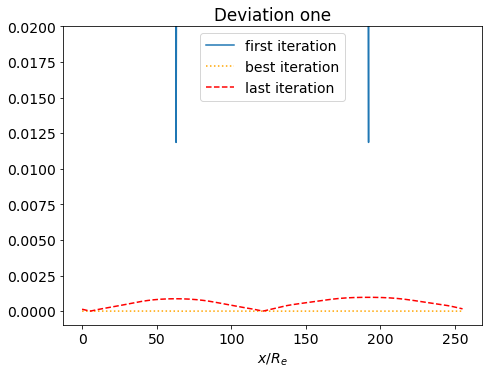

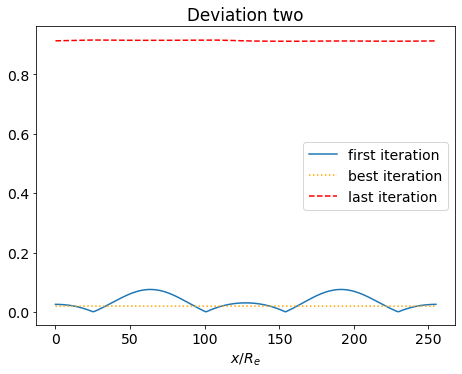

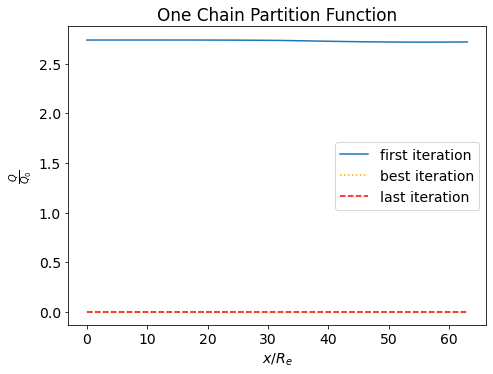

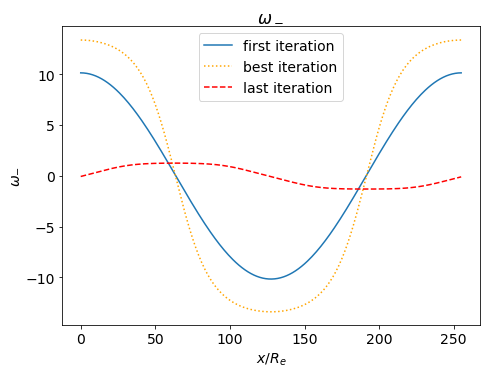

In [71]:
# show the best deviations achieved
max_dev = [max(x) for x in deviation_1]
index_min = np.argmin(max_dev)

plt.figure(figsize=(7.5,5.5))
plt.title("Deviation one")
plt.plot(deviation_1[0], label='first iteration')
plt.plot(deviation_1[index_min], linestyle='dotted' ,color='orange', label='best iteration')
plt.plot(deviation_1[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.ylim(-0.001,0.02)
plt.xlabel(r'$x/R_e$')
plt.legend()
plt.savefig('dev_1.png')


plt.figure(figsize=(7.5,5.5))
plt.title("Deviation two")
plt.plot(deviation_2[-0], label='first iteration')
plt.plot(deviation_2[index_min], linestyle='dotted' ,color='orange',label='best iteration')
plt.plot(deviation_2[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')
plt.legend()
plt.savefig('dev_2.png')


plt.figure(figsize=(7.5,5.5))
plt.title('One Chain Partition Function')
plt.plot(Q0_list[0], label='first iteration')
plt.plot(Q0_list[index_min], linestyle='dotted' ,color='orange',label='best iteration')
plt.plot(Q0_list[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')
plt.ylabel(r'$\frac{Q}{Q_0}$')
plt.legend()
plt.savefig('q_q0_iteration.png')



plt.figure(figsize=(7.5,5.5))
plt.title('$\omega_-$')
plt.plot(w_minus_list[0], label='first iteration')
plt.plot(w_minus_list[index_min], linestyle='dotted' ,color='orange',label='best iteration')
plt.plot(w_minus_list[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.legend()
plt.xlabel(r'$x/R_e$')
plt.ylabel(r'$\omega_{-}$')

plt.savefig('w_minus.png')



### Free Energy calculation
Perform SCFT for several values of L

In [72]:
chi_n = 15
alpha = 0.1
L_list = np.linspace(1.3*Re, 2*Re, 5)
delta_f_list = []

for l in (L_list):
    print("new iteration")
    x = np.linspace(0,Nx, Nx)
    x = x*l/Nx
    
    phi_a_list, phi_b_list, Q0_list ,w_minus_list, w_plus_list, deviation_1, deviation_2 = \
                                    SCFT(x,l, chi_n, alpha)
    #get the position for minimum dev since this diverges sometimes
    max_dev1 = [max(x) for x in deviation_1]
    index_min = np.argmin(max_dev1)
    
    # get free energy
    waf = 0.5*(np.asarray(w_plus_list[index_min]) + np.asarray(w_minus_list[index_min]))
    wbf = 0.5*(np.asarray(w_plus_list[index_min]) - np.asarray(w_minus_list[index_min]))

    delta_f = calculate_free_energy(x, l,waf, wbf,phi_a_list[index_min], phi_b_list[index_min],
                                    Q0_list[index_min],chi_n)
    delta_f_list.append(delta_f)

new iteration
elapsed iterations:  0
current max deviations: (2.8406375000013497, 0.15941472262516143)
new iteration
elapsed iterations:  0
current max deviations: (2.9131314046359744, 0.15134407123836502)
new iteration
elapsed iterations:  0
current max deviations: (2.6451312655445722, 0.13255043694822533)
new iteration
elapsed iterations:  0
current max deviations: (2.1368777134893726, 0.10630617470177262)
new iteration
elapsed iterations:  0
current max deviations: (1.526908625010531, 0.07565050669069928)
elapsed iterations:  500
current max deviations: (0.00033397601208839944, 0.019558435060369583)
elapsed iterations:  1000
current max deviations: (0.02759030778679028, 0.8542188750120369)
elapsed iterations:  1500
current max deviations: (0.006672906399138867, 0.8837208557788437)
elapsed iterations:  2000
current max deviations: (0.0034104506833818604, 0.8960899246413176)
elapsed iterations:  2500
current max deviations: (0.0021898522960996925, 0.9036253251244365)
elapsed iteration

minimum L 2.0


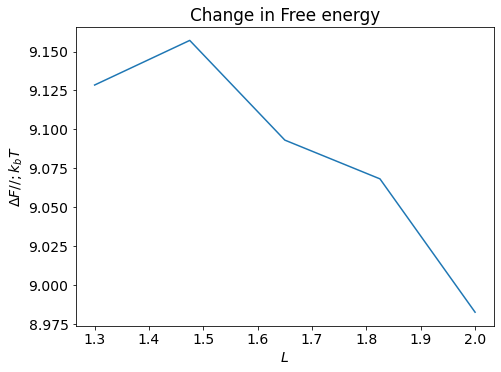

In [74]:
plt.figure(figsize=(7.5,5.5))
plt.plot(L_list, delta_f_list)
plt.title('Change in Free energy')
plt.ylabel(r'$\Delta F //; k_bT$')
plt.xlabel(r'$L$')
plt.savefig('free_energy_L.png')

print("minimum L", L_list[np.argmin(delta_f_list)])

### $L^*$ a function of $\chi N$

In [18]:
delta_f_list

[11.195062430736925,
 11.19097919701818,
 11.15063649435615,
 11.7442497906938,
 nan,
 nan,
 9.97652427177104,
 9.570091746658363,
 9.261393885455277,
 8.982718302791966]

### Repeat scft for xn=20 to generate some fields for the next parts

In [17]:
L = 2*Re
chi_n = 20
alpha = 0.1

phi_a_list, phi_b_list, Q0_list ,w_minus_list, w_plus_list, deviation_1, deviation_2 = \
                    SCFT(x,L, chi_n, alpha)

elapsed iterations:  0
current max deviations: (5.41585620504549, 0.08113011910589796)
elapsed iterations:  500
current max deviations: (7.924998755605259, 0.6364591310642483)
elapsed iterations:  1000
current max deviations: (0.013843777149610936, 0.8931181054407699)
elapsed iterations:  1500
current max deviations: (0.005184427674000958, 0.9066950092202908)
elapsed iterations:  2000
current max deviations: (0.0029911450856463517, 0.914325458400289)
elapsed iterations:  2500
current max deviations: (0.0020388285503158965, 0.919412685135726)


KeyboardInterrupt: 

In [ ]:
alkjaslkdjflkjdf

In [ ]:
#get the position for minimum dev since this diverges sometimes
max_dev1 = [max(x) for x in deviation_1]
index_min = np.argmin(max_dev1)

waf = 0.5*(np.asarray(w_plus_list[index_min]) + np.asarray(w_minus_list[index_min]))
wbf = 0.5*(np.asarray(w_plus_list[index_min]) - np.asarray(w_minus_list[index_min]))

# save the data
np.savetxt('w_a.csv', waf, delimiter=',')
np.savetxt('w_b.csv', wbf, delimiter=',')